In [157]:
using HDF5
using Plots
using LadderDGA
using Suppressor

path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config.toml"
cfg_file2 = "$(@__DIR__)/../../lDGA_test_runs/config2.toml"

empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");

Loading impurity quantities and constructing k grids.
removing the @supress block activates debugging output.

In [158]:
mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
qG = qGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

mP2, sP2, env2, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file2)
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp_fft2, GLoc_fft2, Σ_loc2, FUpDo2, gImp2, gLoc2 = setup_LDGA(kG, freqList, mP2, sP2, env2);

┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:7
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:107
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local susceptibility of length 
│   sp: 11
│   ch: 11 
│   χLoc_sp = 0.2696, χLoc_ch = 0.0932
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:148
┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:7
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:107
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local susceptibility of length 
│   sp: 27
│   ch: 27 
│   χLoc_sp = 0.3231, χLoc_ch = 0.0808
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:148


# Lambda charge solutions investigation

In [159]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

In [160]:
# non local quantities 
bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, qG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, qG, νGrid, sumHelper_f, -mP.U, mP, sP);

In [161]:
# non local quantities 
bubble2 = calc_bubble(νGrid, GLoc_fft2, qG, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, qG, νGrid, sumHelper_f2, mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, qG, νGrid, sumHelper_f2, -mP2.U, mP2, sP2);

In [162]:
sh_1 = LadderDGA.get_sum_helper(nlQ_sp.usable_ω, sP, :b)
sh_12 = LadderDGA.get_sum_helper(nlQ_sp2.usable_ω, sP2, :b)
χspw = LadderDGA.sum_freq(LadderDGA.kintegrate(qG, nlQ_sp.χ[nlQ_sp.usable_ω,:], dim=2)[:,1], [1], sh_1, mP.β)[1]
χspw2 = LadderDGA.sum_freq(LadderDGA.kintegrate(qG, nlQ_sp2.χ[nlQ_sp2.usable_ω,:], dim=2)[:,1], [1], sh_1, mP2.β)[1]

#plot(nlQ_sp.usable_ω, real(impQ_sp.χ_ω[impQ_sp.usable_ω]))
#plot!(nlQ_sp2.usable_ω, real(impQ_sp2.χ_ω[impQ_sp2.usable_ω]))

0.3479159446145041 + 3.21934360230958e-10im

In [163]:
println("$χspw_1 vs $χspw_2\n $χspw2_1 vs $χspw2_2")

LoadError: UndefVarError: χspw_1 not defined

In [164]:
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, νGrid, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill
│    as fill value outside usable ω range. =  as fill value outside usable ω range.
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:142
┌ Warning: currently using min(usable_sp, usable_ch) for all calculations. relax this?
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:26
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 16:26, length: 11
│ ch: 16:26, length: 11
│ usable: 16:26, length: 11
│ χch sum = 0.09201384403481638, rhs = 0.4079861559651836
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:35
┌ Info: found 
│   χ_min = -0.09502768206589088
│   ". Looking for roots in intervall $(int)" = . Looking for roots in intervall [-0.09502768206589088, 1.9005536413178175]
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:134
┌ Info: Method 2 root:
│   r2 = Float64[]
└ @ LadderDGA /home/julian/Hamb

LoadError: TypeError: non-boolean (Vector{Float64}) used in boolean context

In [165]:
λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, qG, νGrid, mP2, sP2)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill
│    as fill value outside usable ω range. =  as fill value outside usable ω range.
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:142
┌ Warning: currently using min(usable_sp, usable_ch) for all calculations. relax this?
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:26
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 8:34, length: 27
│ ch: 9:33, length: 25
│ usable: 9:33, length: 25
│ χch sum = 0.13025453136299703, rhs = 0.36974546863700297
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:35
┌ Info: found 
│   χ_min = -0.08910503113820295
│   ". Looking for roots in intervall $(int)" = . Looking for roots in intervall [-0.08910503113820295, 1.782100622764059]
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:134
┌ Info: Method 2 root:
│   r2 = Float64[]
└ @ LadderDGA /home/julian/Hamburg

LoadError: TypeError: non-boolean (Vector{Float64}) used in boolean context

In [176]:
using Roots

get_sum_helper = LadderDGA.get_sum_helper
kintegrate = LadderDGA.kintegrate
sum_freq = LadderDGA.sum_freq
χ_λ(χ::AbstractArray, λ::Union{Float64}) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
kGrid = qG
β = mP.β


sh = get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = kintegrate(kGrid, nlQ_ch.χ, dim=2)[:,1]
χch_sum = real(sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
rhs1 = mP.n * (1 - mP.n/2) - χch_sum
rhs2 = real(impQ_ch.χ_loc + impQ_sp.χ_loc - χch_sum)
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
sh = get_sum_helper(usable_ω, sP, :b)
χupup_sum = sum_freq(kintegrate(kGrid, 0.5 .* (nlQ_ch.χ[usable_ω,:] .+ nlQ_sp.χ[usable_ω,:]), dim=2)[:,1], [1], sh, mP.β)[1]


sh_2 = get_sum_helper(nlQ_ch2.usable_ω, sP2, :b)
χch_ω_2 = kintegrate(kGrid, nlQ_ch2.χ, dim=2)[:,1]
χch_sum_2 = real(sum_freq(χch_ω_2[nlQ_ch2.usable_ω], [1], sh_2, mP2.β)[1])
rhs1_2 = mP.n * (1 - mP.n/2) - χch_sum_2
rhs2_2 = real(impQ_ch2.χ_loc + impQ_sp2.χ_loc - χch_sum_2)
usable_ω_2 = intersect(nlQ_sp2.usable_ω, nlQ_ch2.usable_ω)
sh_2 = get_sum_helper(usable_ω_2, sP2, :b)
χupup_sum_2 = sum_freq(kintegrate(kGrid, 0.5 .* (nlQ_ch2.χ[usable_ω_2,:] .+ nlQ_sp2.χ[usable_ω_2,:]), dim=2)[:,1], [1], sh_2, mP2.β)[1]

println("usable range: $usable_ω vs $usable_ω_2\nχupup_nc=$χupup_sum\nχupup_rc=$χupup_sum_2")

χ_in = nlQ_sp.χ
usable_ω_i = nlQ_sp.usable_ω
χr    = real.(χ_in[usable_ω_i,:])
sh = get_sum_helper(usable_ω_i, sP, :b)
f(λint) = sum_freq(kintegrate(kGrid, χ_λ(χr, λint), dim=2)[:,1], [1], sh, β)[1] - rhs2
df(λint) = sum_freq(kintegrate(kGrid, -χ_λ(χr, λint) .^ 2, dim=2)[:,1], [1], sh, β)[1]
r2 = find_zeros(f, 0.02, 20.0, verbose=true)

χ_in = nlQ_sp2.χ
usable_ω_i = nlQ_sp2.usable_ω
χr    = real.(χ_in[usable_ω_i,:])
sh = get_sum_helper(usable_ω_i, sP2, :b)
f(λint) = sum_freq(kintegrate(kGrid, χ_λ(χr, λint), dim=2)[:,1], [1], sh, β)[1] - rhs1
df(λint) = sum_freq(kintegrate(kGrid, -χ_λ(χr, λint) .^ 2, dim=2)[:,1], [1], sh, β)[1]
r22 = find_zeros(f, 0.02, 20.0, verbose=true)

println("lambda $r2 vs $r22")

usable range: 16:26 vs 9:33
χupup_nc=0.1866955325096797 - 3.2685805070491504e-10im
χupup_rc=0.2437939692587605 - 3.3498901944799805e-10im
lambda [0.02517019157222132] vs Float64[]


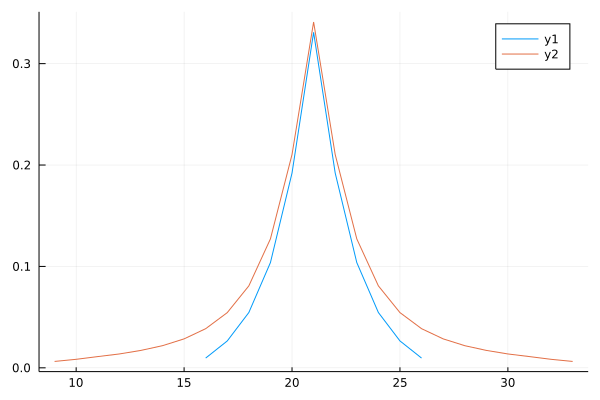

In [178]:
plot(usable_ω, real(χch_ω[usable_ω]))
plot!(usable_ω_2, real(χch_ω_2[usable_ω_2]))

In [167]:
length(usable_ω_2)

25

In [168]:
χupup_1 = nlQ

LoadError: UndefVarError: nlQ not defined

In [169]:
size(bubble)

(41, 20, 40)